# Polar Coding
This Jupyter notebook demonstrates how to use [Polar.jl](https://github.com/jneu-research/Polar.jl) to encode and decode polar codes.
In particular, we evaluate the frame error rates (FER) of the codes designed in notebook `01-code-design-biawgn.ipynb` using [Monte Carlo simulation](https://en.wikipedia.org/wiki/Monte_Carlo_method).
Again, the target is: blocklength $n=128$ (corresponding to $m=7$ polarization steps), dimension $k=64$ (corresponding to rate $R=1/2$), binary-input additive white Gaussian noise (BIAWGN) channel.

## Preparations
Activate project-local Julia environment and load plots library

In [1]:
using Pkg
Pkg.activate(".")

using Plots
pyplot()

Plots.PyPlotBackend()

Load required parts of Polar.jl

In [2]:
# using Revise
using Polar.PolarCodes: PolarCode, polarencode, deinterleave, R, m
using Polar.GF2n: GF2_0, GF2_1, GF2Element
using Polar.CommunicationsUtils: ebn0db2σ²
using Polar.Channels: BiAWGNChannel, get_f, get_llr, mod_bpsk
using Polar.PolarDecoding: SCLDecoder, UnquantizedLLR, UnquantizedPM, decode!, extract_best_pm
using Polar.SimulationUtils: sim_parallel_experiments_fer_simple01, SimulationResult, rate

┌ Warning: Package Polar does not have Plots in its dependencies:
│ - If you have Polar checked out for development and have
│   added Plots as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with Polar
│ Loading Plots into Polar from project dependency, future warnings for Polar are suppressed.
└ @ nothing nothing:840


Frozen vectors of codes designed in `01-code-design-biawgn.ipynb`

In [3]:
frozen_vector_rm = Bool[true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, false, true, true, true, true, true, true, true, false, true, true, true, false, true, false, false, false, true, true, true, true, true, true, true, false, true, true, true, false, true, false, false, false, true, true, true, false, true, false, false, false, true, false, false, false, false, false, false, false, true, true, true, true, true, true, true, false, true, true, true, false, true, false, false, false, true, true, true, false, true, false, false, false, true, false, false, false, false, false, false, false, true, true, true, false, true, false, false, false, true, false, false, false, false, false, false, false, true, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false]
frozen_vector_de = Bool[true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, false, false, true, true, true, true, true, true, true, true, true, true, true, false, true, false, false, false, true, true, true, false, true, false, false, false, true, false, false, false, false, false, false, false, true, true, true, true, true, true, true, false, true, true, true, false, true, false, false, false, true, true, true, false, true, false, false, false, false, false, false, false, false, false, false, false, true, true, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false]
code_rm = PolarCode(frozen_vector_rm)
code_de = PolarCode(frozen_vector_de)

PolarCode{128,64}(fingerprint=bb3206bf4cab7d6e)

## Encoding and decoding basics
The following snippet creates a random payload of length $k=64$, polar-encodes it, modulates it using [BPSK](https://en.wikipedia.org/wiki/Phase-shift_keying#Binary_phase-shift_keying_(BPSK)), ''transmits'' it over a BIAWGN with signal-to-noise ratio $E_\text{b}/N_\text{0} = 2.5\,\text{dB}$, and then decodes it using a successive cancellation list (SCL) decoder with list size $L=32$ and checks whether an error has occurred in the simulated transmission.

In [4]:
EbN0dB = 2.5
L = 32
code = code_de

# prepare BIAWGN at target Eb/N0
σ² = ebn0db2σ²(EbN0dB, R(code))
channel = BiAWGNChannel(σ²)
channel_function_y = get_f(channel)
channel_function_llr = get_llr(channel)

# prepare SCL decoder
decoder = SCLDecoder{m(code),L,UnquantizedLLR,UnquantizedPM,code}()

# encoding
u = rand(GF2Element, 64)
c = polarencode(code, u)

# channel simulation and LLR computation
y = channel_function_y.(c)
llrs = UnquantizedLLR.(channel_function_llr.(y))

# decoding
decode!(decoder, llrs)
(ĉ, pathmetric) = extract_best_pm(decoder)
û = deinterleave(code, ĉ);

# check for transmission error
@show all(u .== û), u .== û;

(all(u .== û), u .== û) = (true, Bool[true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true])


## Distributed Monte Carlo simulations
To evaluate the FER to a desired relative precision usually requires to simulate large numbers of frames, in particular when the FER is close to $0$.
As a rough ballpark, $\approx400$ frame error events are required to achieve a relative precision of $10\%$, $1600$ frame error events are required for $5\%$, and $4300$ frame error events are required for $3\%$.
Furthermore, the FER is usually of interest not only for a fixed channel parameter but for a range of channel parameters, further increasing the number of experiments.
Fortunately, this problem is [embarrassingly parallel](https://en.wikipedia.org/wiki/Embarrassingly_parallel), hence these runs can be run in parallel on a larger number of machines using Julia's [distributed computing infrastructure](https://docs.julialang.org/en/v1/stdlib/Distributed/index.html).

To simplify standard code simulations, Polar.jl comes with convenient wrappers and helpful simulation tools.
In the following, the FER curve is simulated for a BIAWGN with signal-to-noise ratios in the range of $E_\text{b}/N_\text{0} = 1.0\,\text{dB}$ to $E_\text{b}/N_\text{0} = 3.0\,\text{dB}$ and list sizes $L\in\{1,4,32\}$, up to a relative precision of $20\%$:

In [5]:
EbN0dBs = 1.0:0.5:3.0
Ls = [1, 4, 32]
code = code_de

simulation_results = Dict{Tuple{Int,Float64},SimulationResult{(:ListError, :MLError, :PMError)}}()

for L in Ls
    decoder = SCLDecoder{m(code),L,UnquantizedLLR,UnquantizedPM,code}()
    
    for EbN0dB in EbN0dBs
        @show (L, EbN0dB)

        σ² = ebn0db2σ²(EbN0dB, R(code))
        channel = BiAWGNChannel(σ²)

        simulation_results[(L, EbN0dB)] = sim_parallel_experiments_fer_simple01(code, decoder, channel; desired_ci_rel=0.2, desired_ci_event=:PMError)

        @show simulation_results[(L, EbN0dB)]
    end
end

(L, EbN0dB) = (1, 1.0)
  2.581513 seconds (46.12 M allocations: 890.466 MiB, 4.88% gc time)
elapsed time (ns): 2581513002
gc time (ns):      125969995
bytes allocated:   933721183
pool allocs:       46123300
non-pool GC allocs:740
malloc() calls:    15
realloc() calls:   4
GC pauses:         40
simulation_results[(L, EbN0dB)] = SimulationResult{(:ListError, :MLError, :PMError)}(Dict(:ListError=>8341,:PMError=>8341,:ANY=>19200,:MLError=>2860))
(L, EbN0dB) = (1, 1.5)
  1.152014 seconds (38.65 M allocations: 668.405 MiB, 7.01% gc time)
elapsed time (ns): 1152014186
gc time (ns):      80776840
bytes allocated:   700873808
pool allocs:       38654277
non-pool GC allocs:1
GC pauses:         31
simulation_results[(L, EbN0dB)] = SimulationResult{(:ListError, :MLError, :PMError)}(Dict(:ListError=>5166,:PMError=>5166,:ANY=>19200,:MLError=>1489))
(L, EbN0dB) = (1, 2.0)
  1.025017 seconds (35.24 M allocations: 614.902 MiB, 7.22% gc time)
elapsed time (ns): 1025017365
gc time (ns):      74057342
by

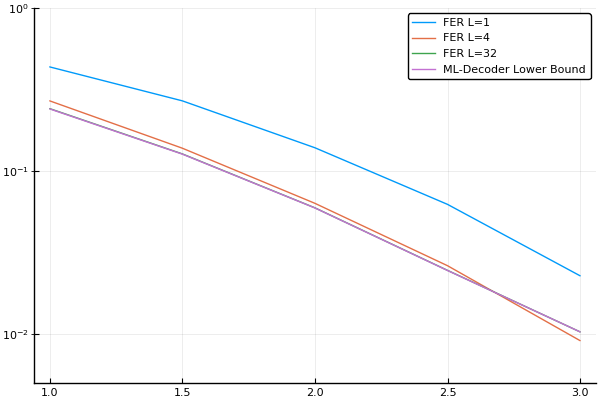

In [6]:
p = plot(yscale=:log10, yticks=[0.001, 0.01, 0.1, 1.0], ylim=(0.005, 1))
for L in Ls
    plot!(EbN0dBs, x -> rate(simulation_results[(L, x)], :PMError), label="FER L=$(L)")
end
plot!(EbN0dBs, x -> rate(simulation_results[(32, x)], :MLError), label="ML-Decoder Lower Bound")
p